In [1]:
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
from torchvision import models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print(device)

cuda:0


In [5]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

# Data
0->Covid<br>
1->No Covid

In [6]:
classes=['Covid','No Covid']

In [18]:
num_classes=2
batch_size=4

In [19]:
# reshape all images to 64x64 and apply tensor transformation
dataset = torchvision.datasets.ImageFolder(root="./data",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227]),
#                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                                            # transforms.Grayscale(num_output_channels=1)
                                                            ]))
# testset = torchvision.datasets.ImageFolder(root="./xray",train=False,transform=transforms.Compose([transforms.Resize([300,305]),transforms.ToTensor()]))
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

In [20]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

8088


In [10]:
def plot_img(img):
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [11]:
%%notify -m "completed"
dataiter=iter(trainloader)
images,labels=dataiter.next()
img=images[0]
print(type(img))
npimg=img.numpy()
print(npimg.shape)

<class 'torch.Tensor'>
(3, 227, 227)


<IPython.core.display.Javascript object>

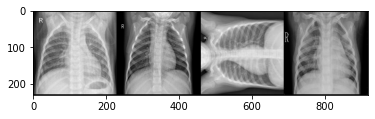

No Covid No Covid No Covid No Covid 

In [12]:
plot_img(torchvision.utils.make_grid(images))
for i in range(4):
    print(classes[labels[i]],end=" ")

# Preparing The CNN

In [13]:
def evaluation(dataloader,model):
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
    print(correct,total)
    model.train()
    return 100*correct/total

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.representation_network=nn.Sequential(
            nn.Conv2d(3,128,5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,64,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,32,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classification_network=nn.Sequential(
            nn.Linear(21632,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,1)
#             nn.Sigmoid()
        )
    def forward(self,x):
        # print(x.shape)
        x=self.representation_network(x)
#         print(x.shape)
        # flattening of the vector=> same dimension of first index(batch size) , everythign else is flattened(-1)
        x=x.view(x.size(0),-1)
#         print(x.shape)
        x=self.classification_network(x)
        # print(x.shape)
        return x

In [15]:
from sklearn.model_selection import KFold

In [16]:
def k_fold_cv(model,dataset,loss_function,k_folds=5,epochs=10):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)): 
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
              dataset, 
              batch_size=batch_size, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
              dataset,
              batch_size=batch_size, sampler=test_subsampler)

        # Init the neural network
        network = model
        reset_weights(network)
        optimizer = optim.Adam(network.parameters())
        # Run the training loop for defined number of epochs
        for epoch in range(0, epochs):

            # Print epoch
            print(f'Starting epoch {epoch+1}')

            # Set current loss value
            current_loss = 0.0

            # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):

                # Get inputs
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                # Zero the gradients
                optimizer.zero_grad()

                # Perform forward pass
                outputs = network(inputs)
                targets = targets.unsqueeze(-1)
                targets = targets.type_as(outputs)
                # Compute loss
                loss = loss_function(outputs, targets)

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()

                # Print statistics
                current_loss += loss.item()
                if i % 500 == 499:
                    print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 500))
                    current_loss = 0.0

        # Process is complete.
        print('Training process has finished. Saving the trained model.')
        save_path = f'./CNN3-fold-{fold}.pth'
        torch.save(network, save_path)

        # Evaluation for this fold
        correct, total = 0, 0
        with torch.no_grad():

            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                inputs,targets=inputs.to(device),targets.to(device)
                # Generate outputs
                outputs = network(inputs)
                m = nn.Sigmoid()
                outputs=m(outputs)
                pred=outputs>=0.5
                pred=pred.flatten()
                # Set total and correct
                total += targets.size(0)
                correct += (pred == targets).sum().item()

            # Print accuracy
            print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
            print('--------------------------------')
            results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

In [17]:
def train(net,dataloader,epochs=15):
    loss_fn=nn.BCEWithLogitsLoss().to(device)
    opt=optim.Adam(params=net.parameters())
    for epoch in range(epochs):
        for i,data in enumerate(dataloader,0):
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            opt.zero_grad()
            outputs=net(inputs)
            labels=labels.unsqueeze(-1)
            labels = labels.type_as(outputs)
    #         print(outputs)
            loss=loss_fn(outputs,labels)
            loss.backward()
            opt.step()
            torch.cuda.empty_cache()
            del inputs,labels,outputs

CNN3

In [27]:
def reset_weights(m):
    m.load_state_dict(torch.load("./CNN3_Original_state.pt"))

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.representation_network=nn.Sequential(
            nn.Conv2d(3,32,3), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2,stride=3),
            nn.Conv2d(32,32,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=3),
        )
        self.classification_network=nn.Sequential(
            nn.Linear(18432,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,1)
#             nn.Sigmoid()
        )
    def forward(self,x):
        # print(x.shape)
        x=self.representation_network(x)
#         print(x.shape)
        # flattening of the vector=> same dimension of first index(batch size) , everythign else is flattened(-1)
        x=x.view(x.size(0),-1)
#         print(x.shape)
        x=self.classification_network(x)
        # print(x.shape)
        return x

In [25]:
net=CNN().to(device)
loss_fn=nn.BCEWithLogitsLoss().to(device)
data_set=trainset
path="./CNN3_Original_state.pt"
torch.save(net.state_dict(),path)
k_fold_cv(net,data_set,loss_fn,epochs=10)

FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 0.593
Loss after mini-batch  1000: 0.393
Starting epoch 2
Loss after mini-batch   500: 0.315
Loss after mini-batch  1000: 0.312
Starting epoch 3
Loss after mini-batch   500: 0.221
Loss after mini-batch  1000: 0.234
Starting epoch 4
Loss after mini-batch   500: 0.207
Loss after mini-batch  1000: 0.187
Starting epoch 5
Loss after mini-batch   500: 0.183
Loss after mini-batch  1000: 0.172
Starting epoch 6
Loss after mini-batch   500: 0.123
Loss after mini-batch  1000: 0.138
Starting epoch 7
Loss after mini-batch   500: 0.111
Loss after mini-batch  1000: 0.124
Starting epoch 8
Loss after mini-batch   500: 0.087
Loss after mini-batch  1000: 0.095
Starting epoch 9
Loss after mini-batch   500: 0.077
Loss after mini-batch  1000: 0.082
Starting epoch 10
Loss after mini-batch   500: 0.059
Loss after mini-batch  1000: 0.084
Training process has finished. Saving the trained model.
Accuracy for fold 0: 92 %
------

In [31]:
reset_weights(net)
train(net,trainloader)

In [26]:
evaluation(testloader,net)

1486 1618


91.84177997527811

In [33]:
torch.save(net,"CNN-3_final.pth")

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [23]:
def report(dataloader,model):
    y_true,y_pred=torch.tensor([]),torch.tensor([])
    model.eval()
    with torch.no_grad():
        total,correct=0,0
        for data in dataloader:
            inputs,labels=data
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
    #         print(outputs)
    #         print(outputs,labels)
            m = nn.Sigmoid()
            outputs=m(outputs)
            pred=outputs>=0.5
            pred=pred.flatten()
            y_true=torch.cat((y_true,copy.deepcopy(labels.cpu())),0)
            y_pred=torch.cat((y_pred,copy.deepcopy(pred.cpu())),0)
#             print(y_pred,y_true,y_pred==y_true,pred==labels)
            total+=labels.size(0)
            # labels=torch.add(labels,-1)
            # print(pred,labels)
    #         print(list(map(lambda a: classes[a],pred)),list(map(lambda a: classes[a],labels)))
            correct+=(pred==labels).sum().item()
#             print((pred==labels).sum())
    print("Accuracy: ",accuracy_score(y_true,y_pred))
    print("Precision: ",precision_score(y_true,y_pred))
    print("Recall: ",recall_score(y_true,y_pred))
    print("F1-Score: ",f1_score(y_true,y_pred))
    print("AUC: ",roc_auc_score(y_true,y_pred))
    print(correct,total)
#     print(y_true,y_pred)
    y_pred=y_pred.flatten()
    y_true=y_true.flatten()
#     print(classification_report(y_true, y_pred))
    
    model.train()
    return 100*correct/total

In [24]:
print(report(testloader,net))

Accuracy:  0.9184177997527813
Precision:  0.9063981042654028
Recall:  0.9352078239608802
F1-Score:  0.9205776173285198
AUC:  0.9182289119804401
1486 1618
91.84177997527811
